In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('hip_hop_train.csv', sep='|')

In [3]:
# Define features to analyze
features = [
            'danceability',
            'energy',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'num_samples',
            'end_of_fade_in',
            'start_of_fade_out',
            'loudness',
            'tempo',
            'key',
            'mode',
            'bars_num',
            'bars_duration_mean',
            'bars_duration_var',
            'beats_num',
            'beats_duration_mean',
            'beats_duration_var',
            'sections_num',
            'sections_duration_mean',
            'sections_duration_var',
            'loudness_var',
            'tempo_var',
            'key_var',
            'mode_var',
            'segments_num',
            'segments_duration_var',
            'segments_duration_mean',
            'pitches_mean',
            'pitches_var',
            'timbre_mean',
            'timbre_var',
            'tatums_num',
            'tatums_duration_mean',
            'tatums_duration_var'
           ]

feat_df = df[features].copy()

## Did a correlation analysis already for jazz analysis, so skipping that here. Going directly to distribution analysis

In [4]:
cols_to_drop = [
                'start_of_fade_out',
                'bars_duration_mean',
                'beats_duration_mean',
                'tatums_duration_mean',
                'tatums_num',
                'beats_num',
                'segments_num'
               ]

feat_df.drop(
             cols_to_drop,
             axis = 1,
             inplace = True
            )

## Now let's take a look at the distribution of the remaining features

C:\Users\Alexander\anaconda3\envs\playlistenv\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


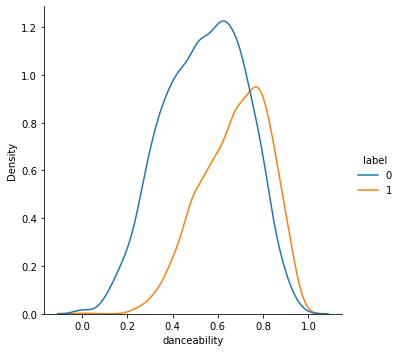

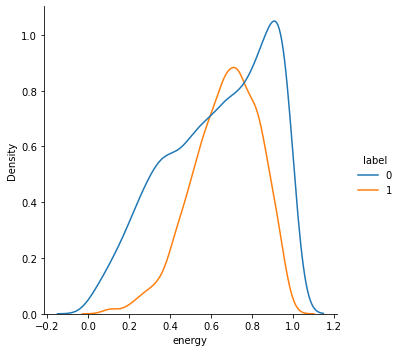

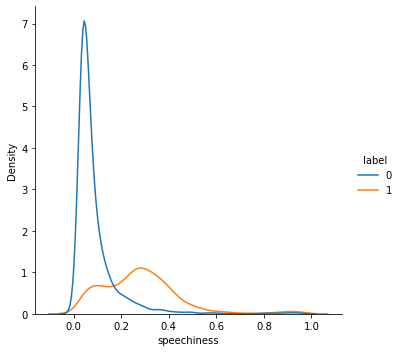

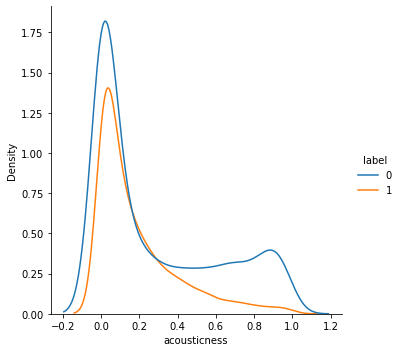

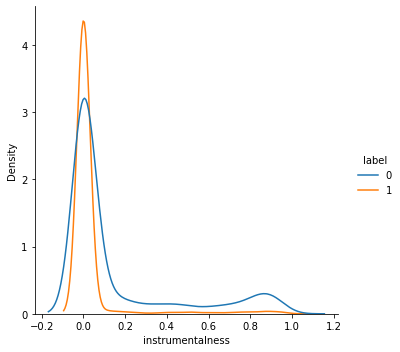

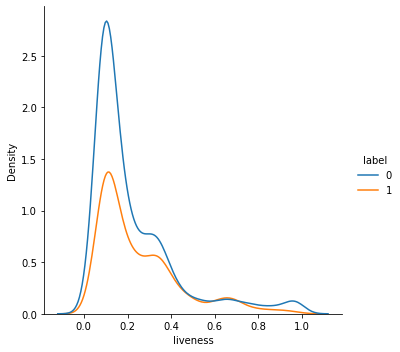

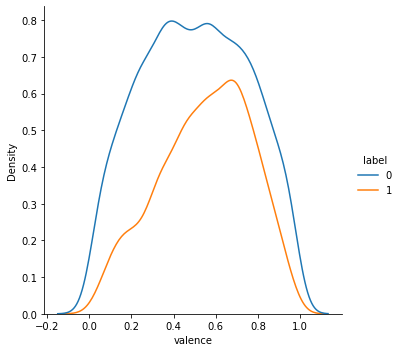

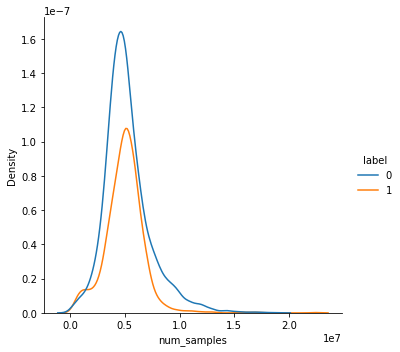

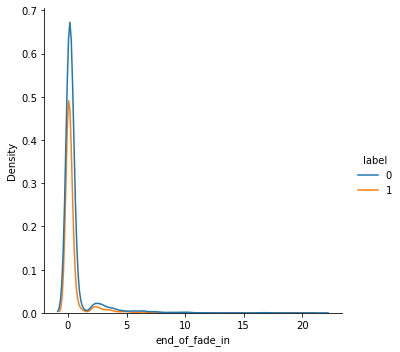

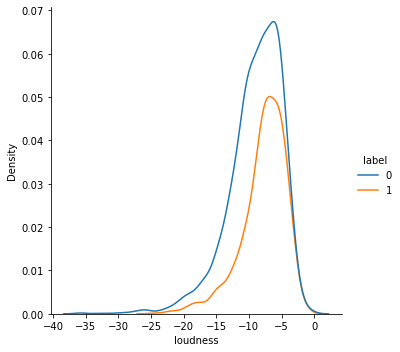

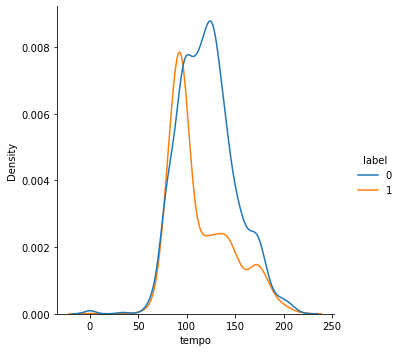

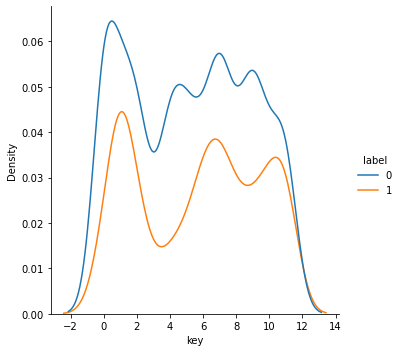

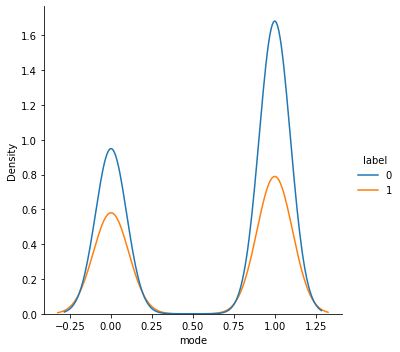

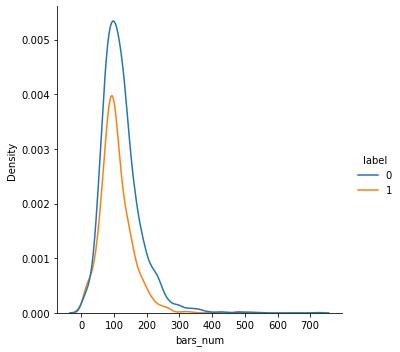

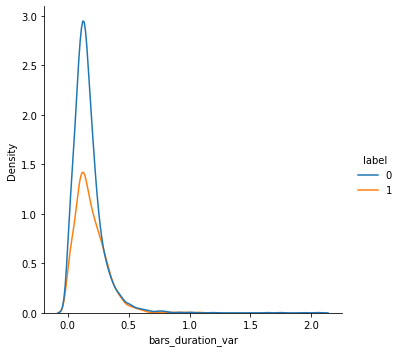

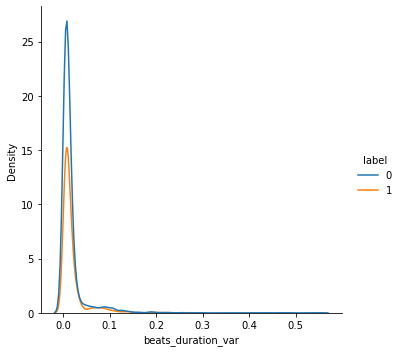

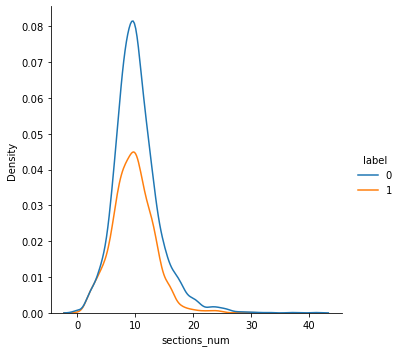

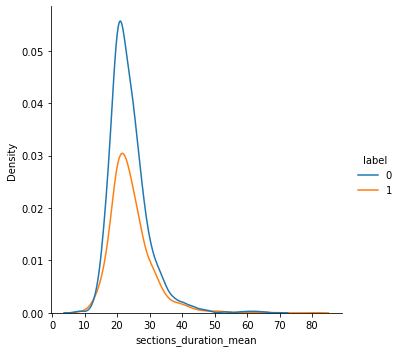

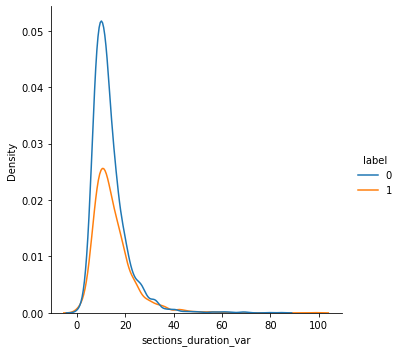

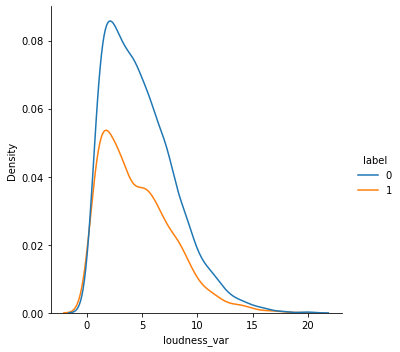

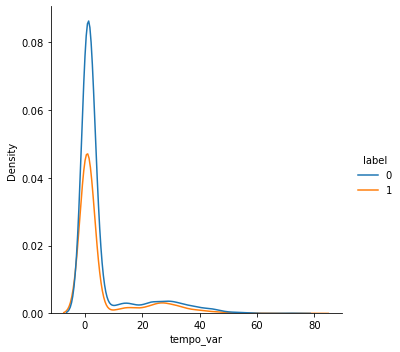

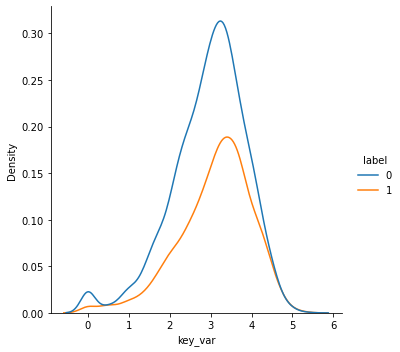

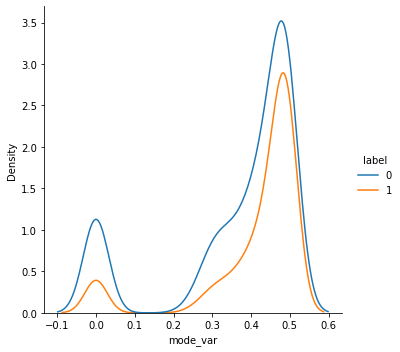

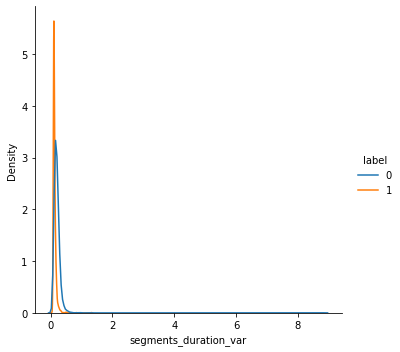

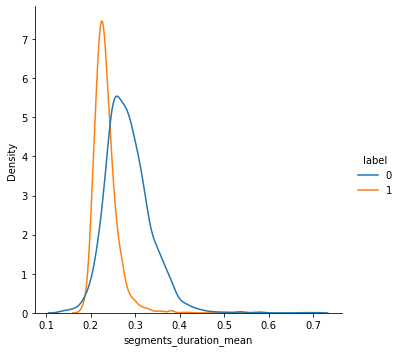

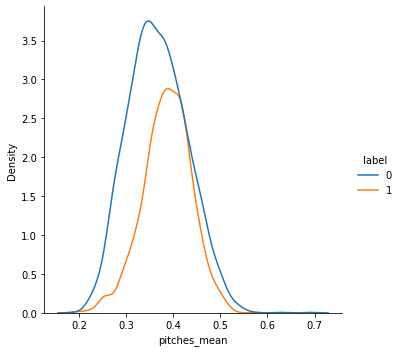

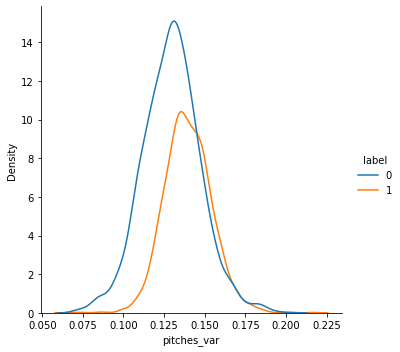

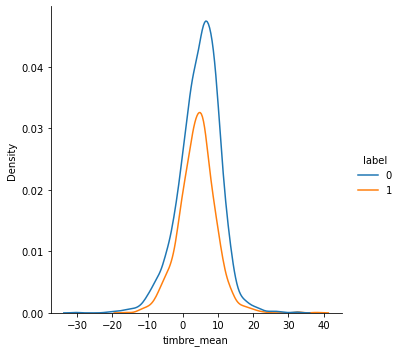

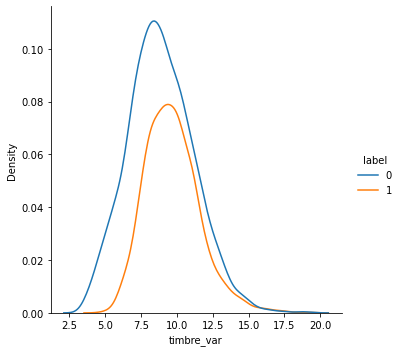

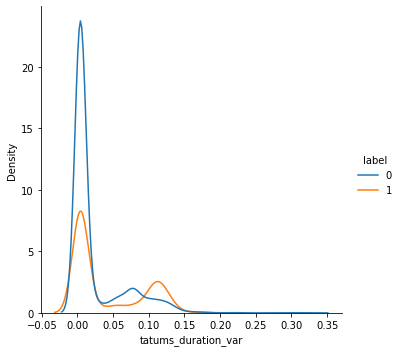

In [5]:
for col in [feat for feat in features if feat not in cols_to_drop]:
    sns.displot(df, x=col, kind='kde', hue='label')

end_of_fade_in, loudness, tempo, key, bars_num, sections_num, sections_duration_mean, sections_duration_var, loudness_var, tempo_var, key_var, segments_duration_var, timbre_mean, and timbre_var needs to be standardized if I want similar ranges for all variables. 

In [6]:
scale_feats = [
               'end_of_fade_in',
               'loudness', 
               'tempo',
               'key',
               'bars_num', 
               'sections_num',
               'sections_duration_mean',
               'sections_duration_var',
               'loudness_var',
               'tempo_var',
               'key_var',
               'segments_duration_var',
               'timbre_mean',
               'timbre_var'
              ]
train_feats = [f for f in features if f not in cols_to_drop]


## Now, let's see if we can see how the data cluster

This is for visualization, so I will do a PCA first to get the data down to 3 dimensions

In [7]:
# First standardize the features in need of standardization
scaler = Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

scaled_df = pd.DataFrame(scaler.fit_transform(feat_df), columns=train_feats)

In [8]:
pca = PCA(n_components = 3)
pca_model = pca.fit(scaled_df)
pca_df = pd.DataFrame(pca_model.transform(scaled_df), columns=['component_1', 'component_2', 'component_3'])\
           .join(df['label'])

In [9]:
explained_variance = pca_model.explained_variance_
print('Explained variances are {} for component 1, {} for component 2, and {} for component 3.'\
      .format(round(explained_variance[0], 2), round(explained_variance[1], 2), round(explained_variance[2], 2)))

Explained variances are 3.95 for component 1, 3.16 for component 2, and 2.71 for component 3.


In [10]:
var_ratios = pca_model.explained_variance_ratio_
print('Component 1 explains {}% of the variation, component 2 {}% of the variation, and component 3 {}% of the variation'\
      .format(round(var_ratios[0]*100, 0), round(var_ratios[1]*100, 0), round(var_ratios[2]*100, 0)))

Component 1 explains 13.0% of the variation, component 2 11.0% of the variation, and component 3 9.0% of the variation


Together the 3 top components that I plan to plot explains 33% of the variance, so the following plots will only give a small part of the story, but might give some indicators towards the linearity of the data.

<AxesSubplot:xlabel='component_2', ylabel='component_3'>

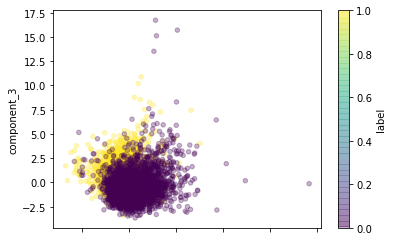

In [11]:
pca_df.plot.scatter('component_2', 'component_3', c='label', colormap='viridis', alpha=0.3)

Seems to be a bit of overlap, but more separation than with jazz music, as expected, since I'm now planning to train for a more narrow range of music (hip hop vs "jazzy" music of various genres)

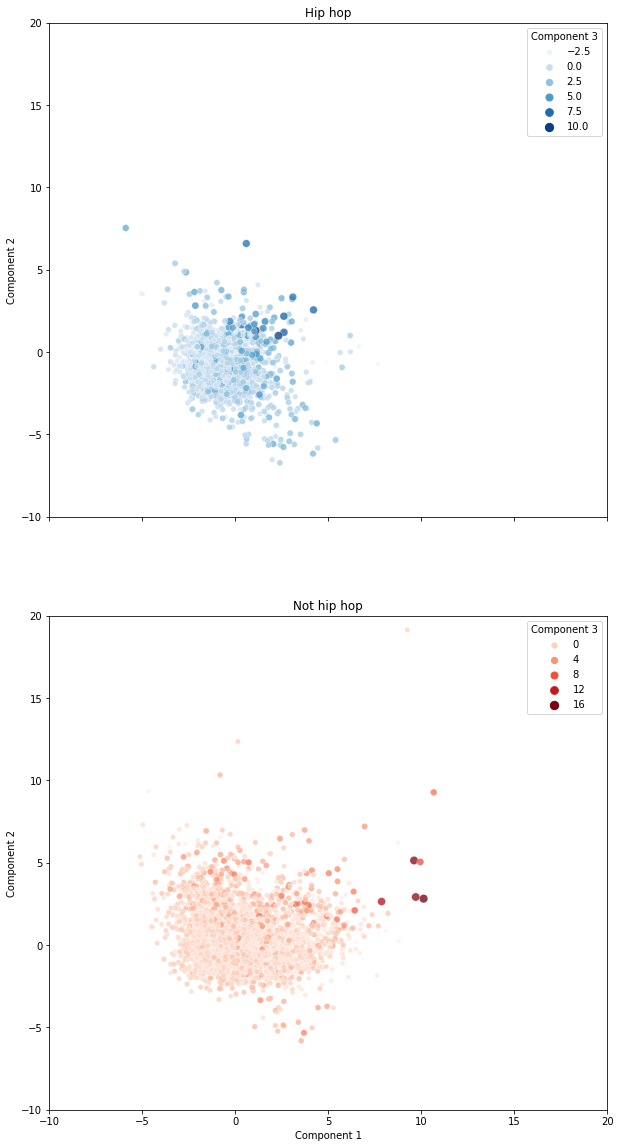

In [13]:
pos_df = pca_df[pca_df['label']==1].copy()
neg_df = pca_df[pca_df['label']==0].copy()

fig, axes = plt.subplots(2,1,figsize=(10,20), subplot_kw={'xlim': (-10,20), 'ylim': (-10, 20)}, sharex=True)
sns.scatterplot(
                data = pos_df,
                x = 'component_1',
                y = 'component_2',
                hue = 'component_3',
                size = 'component_3',
                palette = 'Blues',
                alpha = 0.75,
                ax = axes[0]
               )
axes[0].set_title('Hip hop')
axes[0].set_ylabel('Component 2')
axes[0].patch.set_alpha(1)
axes[0].legend(title='Component 3')
# plt.gca().set_aspect('equal', adjustable='box')
sns.scatterplot(
                data = neg_df,
                x = 'component_1',
                y = 'component_2',
                hue = 'component_3',
                size = 'component_3',
                palette = 'Reds',
                alpha = 0.75,
                ax = axes[1]
               )
axes[1].set_title('Not hip hop')
axes[1].patch.set_alpha(1)
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')
axes[1].legend(title='Component 3')

Seems to be significant differentiation at 3rd dimension where there is overlap on other dimensions. Looks very promising!